In [10]:
import os
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

In [11]:
class HashtagDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.hashtag_df = pd.read_csv(csv_file, sep=" ")
        self.transform = transform
        self.num_hashtags = 0
        self.index2hashtag = {}
        self.hashtag2index = {}
        self.create_index()
    
    def create_index(self):
        for i, row in self.hashtag_df.iterrows():
            hashtags = row["hashtags"].split(",")
            for hashtag in hashtags:
                if hashtag not in self.hashtag2index:
                    self.hashtag2index[hashtag] = self.num_hashtags
                    self.index2hashtag[self.num_hashtags] = hashtag
                    self.num_hashtags += 1
    
    def __len__(self):
        return len(self.hashtag_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.hashtag_df.iloc[idx]["image_path"])
        image = Image.open(img_name)
        image = image.convert('RGB')
        
        hashtags = self.hashtag_df.iloc[idx]["hashtags"]
        hashtags_list = hashtags.split(",")
        
        labels = np.zeros(self.num_hashtags).astype(np.int16)
        
        for hashtag in hashtags_list:
            labels[self.hashtag2index[hashtag]] = 1
        
        if self.transform:
            image = self.transform(image)
            labels = torch.from_numpy(labels.T)
        
        return image, labels    

#### Train and Val Transforms

In [12]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#### Image visualizations

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#### Train and Validation Dataset

In [14]:
train_dataset = HashtagDataset(root_dir="/media/iiit/EXTERNAL/IRE_hashtag_data", 
                               csv_file="train.csv", 
                               transform=train_transform)

val_dataset = HashtagDataset(root_dir="/media/iiit/EXTERNAL/IRE_hashtag_data", 
                               csv_file="val.csv",
                               transform=val_transform)

#### Train and Validation dataloader

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

#### Visualize images

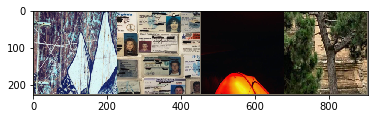

In [16]:
# Get a batch of training data
inputs, labels = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

### Training

In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader   

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    accuracy = compute_accuracy(labels, outputs)
#                     _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
for i, (inp, labels) in enumerate(train_dataloader):
    print(inp.size(), labels.size())

torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])


torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])


torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])


torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])


torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])


torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])


torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])


torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])


torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])


torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
torch.Size([4, 3, 224, 224]) torch.Size([4, 100])
